# Predicting Price

## Outline

- [Objective](#objective)
- [Setup](#setup)
- [Data Exploration](#data-exploration)
- [Data Processing](#data-processing)
    - [Data Type Changing](#data-type-changing)
    - [Check outliers and correlations](#outliers-correlations)
    - [Feature selection](#feature-selection)
        - [Best 5 features](#best-five-features)
        - [Best 3 features](#best-three-features)
- [Machine Learning](#machine-learning)
    - [Regression Models](#regression-models)
    - [Model Evaluation](#model-evaluation)
        - [Highest R Squared](#highest-r-squared)
        - [Minimum Train Error](#min-train-error)
        - [Minimum Test Error](#min-test-error)
    - [Grid Search in Random Forest](#grid-search-random-forest)
    - [Scaling](#scaling)
        - [Min-Max Scaling](#min-max-scaling)
        - [Standard Scaling](#standard-scaling)
        - [Robust Scaling](#robust-scaling)
    - [Visualize Machine Learning Model Results](#ml-model-results)
- [Deep Learning](#deep-learning)

## Objective <a id='objective'></a>

The target variable is price. 

There are 7 features, and the objective is to build a machine learning model to predict prices.

1. Exploratory data analysis to find insights on data structures and how features are related.
2. Fit machine learning models and discuss the rationale for choices.
3. Show the power of a model with cross validation and discuss results.
4. Present results and discuss next steps.

## Setup <a id='setup'></a>

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import time

# Machine learning
from sklearn import tree, svm, neighbors, linear_model
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, get_scorer_names
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep learning
import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

In [2]:
# Read data
df = pd.read_csv('data/raw/sample.csv')

## Data Exploration <a id='data-exploration'></a>

In [3]:
# Show first 5 rows
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,01,1,Mon,662,3000.0,3.8,73.49
1,9,99,1,Thu,340,2760.0,9.2,300.00
2,0,04,0,Mon,16,2700.0,3.0,130.00
3,4,40,1,Mon,17,12320.0,6.4,365.00
4,5,50,1,Thu,610,2117.0,10.8,357.50


In [4]:
# Information on DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   loc1    10000 non-null  object 
 1   loc2    10000 non-null  object 
 2   para1   10000 non-null  int64  
 3   dow     10000 non-null  object 
 4   para2   10000 non-null  int64  
 5   para3   10000 non-null  float64
 6   para4   10000 non-null  float64
 7   price   10000 non-null  float64
dtypes: float64(3), int64(2), object(3)
memory usage: 625.1+ KB


## Data Processing <a id='data-processing'></a>

In [5]:
# Count unique values in `loc1`
df['loc1'].value_counts()

loc1
2    1607
0    1486
1    1223
7    1081
3     945
5     846
4     773
8     727
9     690
6     620
S       1
T       1
Name: count, dtype: int64

In [6]:
# Remove rows where `loc1` column contains 'S' or 'T'
df = df[~df['loc1'].isin(['S', 'T'])]

In [7]:
# Count unique values in `loc2`
df['loc2'].value_counts()

loc2
21    499
06    454
74    329
12    273
14    246
     ... 
43      1
0T      1
0L      1
0C      1
0N      1
Name: count, Length: 105, dtype: int64

In [8]:
# Convert values in `loc1` to numeric values with errors resulting in NaN values
df['loc1'] = pd.to_numeric(df['loc1'], errors='coerce')

# Convert values in `loc2` to numeric values with errors resulting in NaN values
df['loc2'] = pd.to_numeric(df['loc2'], errors='coerce')

In [9]:
# Drop missing values
df = df.dropna()

In [10]:
# Check shape of DataFrame
df.shape

(9993, 8)

### Data Type Changing <a id='data-type-changing'></a>

In [11]:
# Convert `dow` variable into dummy/indicator variables
dow_dummies = pd.get_dummies(df['dow'])

In [12]:
# Show first 5 rows
dow_dummies.head()

,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,False,True,False,False,False,False,False
1,False,False,False,False,True,False,False
2,False,True,False,False,False,False,False
3,False,True,False,False,False,False,False
4,False,False,False,False,True,False,False


In [13]:
# Create deep copy of DataFrame
df2 = df.copy(deep=True)

In [14]:
# Drop `dow` column
df2 = df2.drop(columns='dow')

In [15]:
# Merge DataFrames with left join
result = df2.join(dow_dummies)

In [16]:
# Show first 5 rows
result.head()

,loc1,loc2,para1,para2,para3,para4,price,Fri,Mon,Sat,Sun,Thu,Tue,Wed
0,0,1.0,1,662,3000.0,3.8,73.49,False,True,False,False,False,False,False
1,9,99.0,1,340,2760.0,9.2,300.00,False,False,False,False,True,False,False
2,0,4.0,0,16,2700.0,3.0,130.00,False,True,False,False,False,False,False
3,4,40.0,1,17,12320.0,6.4,365.00,False,True,False,False,False,False,False
4,5,50.0,1,610,2117.0,10.8,357.50,False,False,False,False,True,False,False


In [17]:
# Replace day of week with numerical value in original DataFrame
df['dow'] = df['dow'].replace(to_replace={'Mon': 1, 'Tue': 2, 'Wed': 3, 'Thu': 4, 'Fri': 5, 'Sat': 6, 'Sun': 7})

In [18]:
# Show first 5 rows
df.head()

,loc1,loc2,para1,dow,para2,para3,para4,price
0,0,1.0,1,1,662,3000.0,3.8,73.49
1,9,99.0,1,4,340,2760.0,9.2,300.00
2,0,4.0,0,1,16,2700.0,3.0,130.00
3,4,40.0,1,1,17,12320.0,6.4,365.00
4,5,50.0,1,4,610,2117.0,10.8,357.50


### Check outliers and correlations <a id='outliers-correlations'><a>

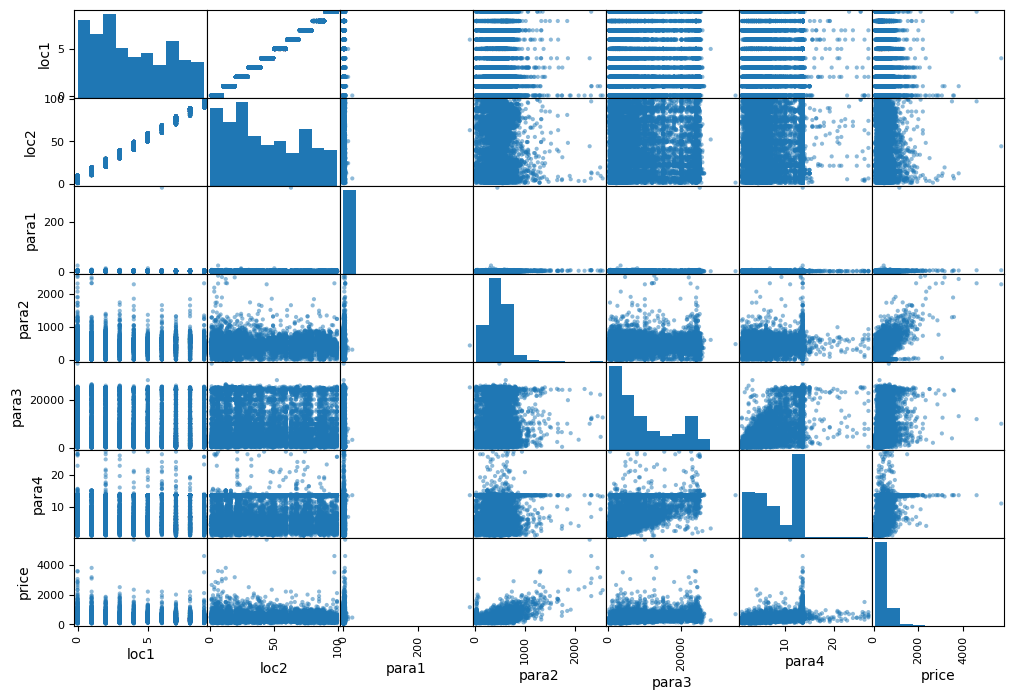

In [19]:
# Scatter matrix of feature variables
_ = scatter_matrix(result.iloc[:, 0:7], figsize=(12, 8))

In [20]:
# Show absolute correlation values between `price` column and all other columns in DataFrame
pd.DataFrame(abs(result.corr()['price'])).sort_values(by='price', ascending=False)[1::]

,price
para2,0.551222
para4,0.517614
para3,0.356949
para1,0.074555
loc1,0.044079
loc2,0.043543
Wed,0.026684
Fri,0.025674
Mon,0.021734
Thu,0.019656


In [21]:
# Drop `loc2` column
result = result.drop(columns='loc2')

In [22]:
# Show all rows and first 6 columns
result.iloc[:, 0:6]

,loc1,para1,para2,para3,para4,price
0,0,1,662,3000.0,3.8,73.49
1,9,1,340,2760.0,9.2,300.00
2,0,0,16,2700.0,3.0,130.00
3,4,1,17,12320.0,6.4,365.00
4,5,1,610,2117.0,10.8,357.50
...,...,...,...,...,...,...
9995,9,3,386,5000.0,12.0,460.00
9996,7,1,386,3250.0,8.0,325.00
9997,0,0,190,8856.0,5.6,133.33
9998,7,3,717,5000.0,13.6,820.00


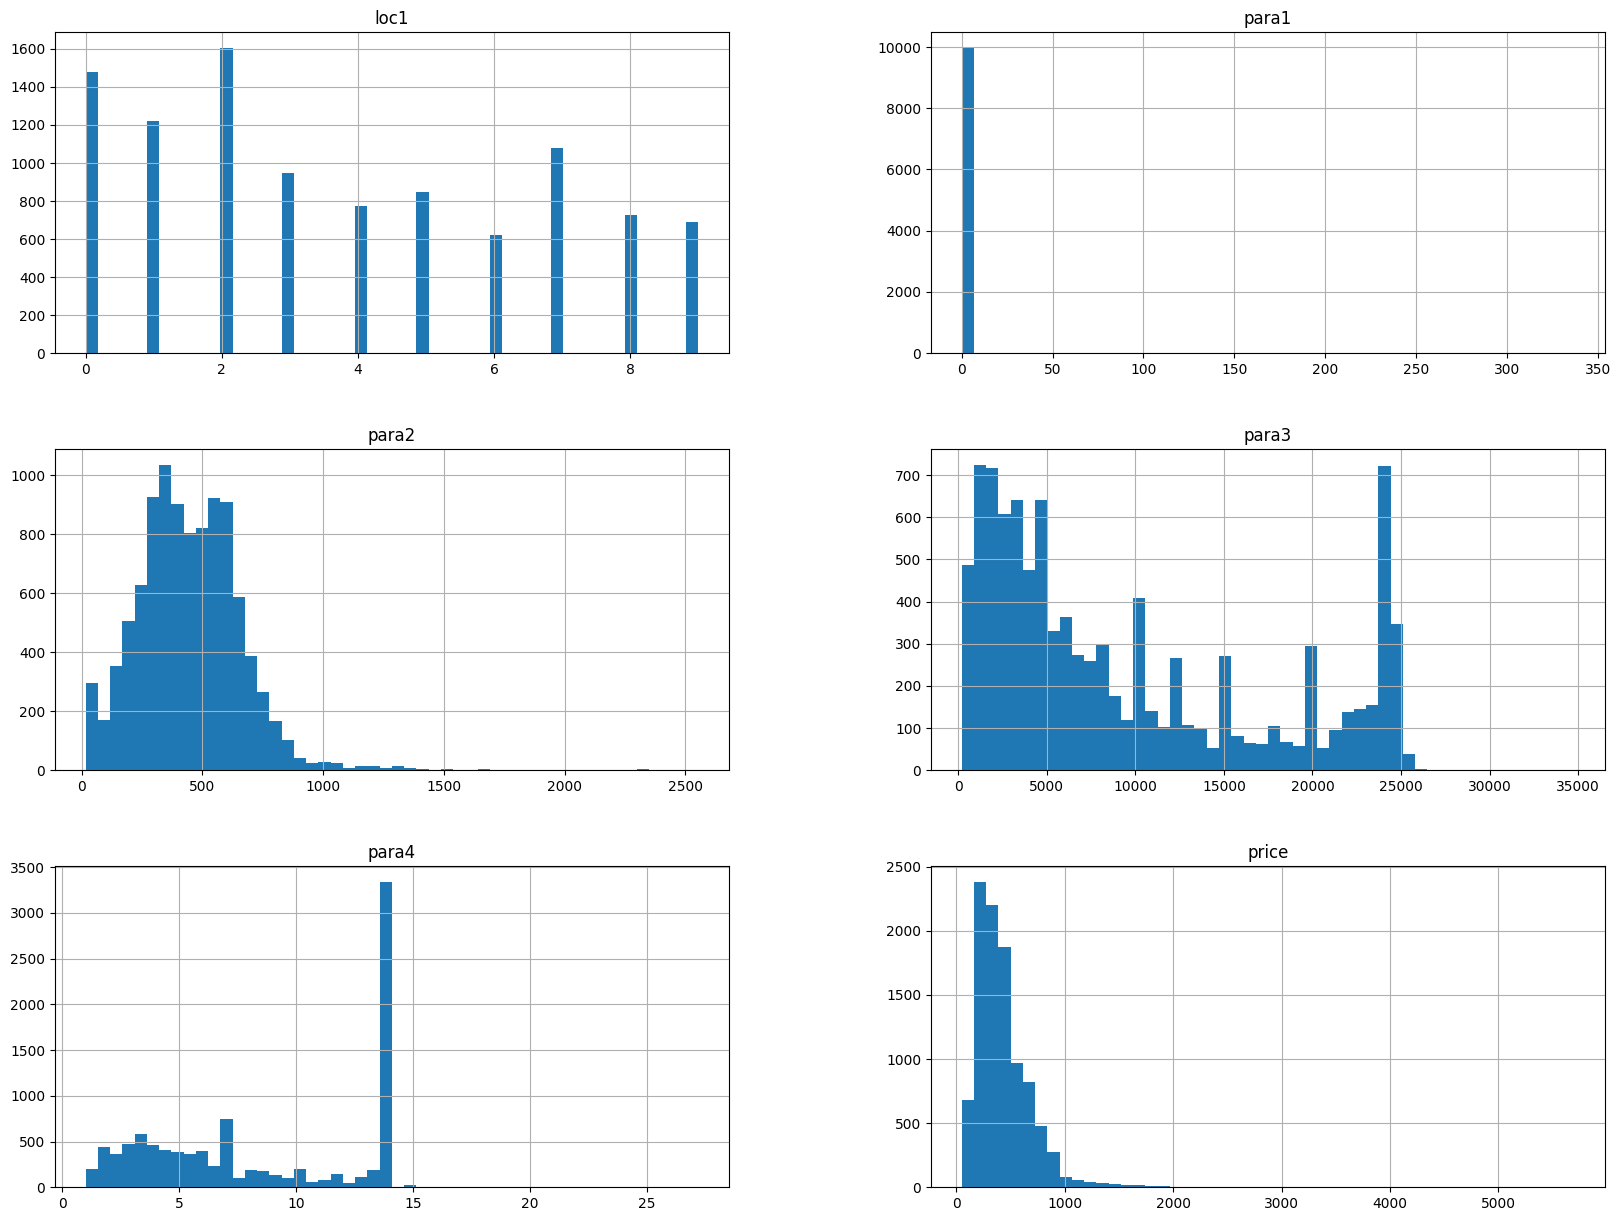

In [23]:
# Plot histograms for first 6 columns in result
result.iloc[:, 0:6].hist(bins=50, figsize=(20, 15))

# Display plot
plt.show()

In [24]:
# Summary statistics for first 6 columns in result
result.iloc[:, 0:6].describe()

,loc1,para1,para2,para3,para4,price
count,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000,9993.000000
mean,3.793355,1.379966,446.888522,9550.105894,8.460614,433.318379
std,2.892286,3.501891,220.141080,8022.655794,4.613156,276.743453
min,0.000000,0.000000,16.000000,200.000000,1.000000,50.730000
25%,1.000000,1.000000,301.000000,2900.000000,4.000000,250.000000
50%,3.000000,1.000000,434.000000,6448.000000,7.200000,370.000000
75%,6.000000,1.000000,582.000000,15000.000000,13.600000,550.000000
max,9.000000,337.000000,2554.000000,34782.000000,27.200000,5700.000000


In [25]:
# Sort values by `para1` variable in descending order, show first 5 rows
result.iloc[:, 0:6].sort_values(by='para1', ascending=False).head()

,loc1,para1,para2,para3,para4,price
7196,6,337,442,25000.0,13.6,1150.0
1561,0,24,314,3360.0,13.6,450.0
8328,5,13,292,2528.0,6.8,350.0
4522,2,13,363,7920.0,13.2,490.0
7198,2,9,583,6600.0,12.0,730.0


In [26]:
# Count unique values for `para1` column
result['para1'].value_counts()

para1
1      7052
3      1609
0       836
2       265
4       164
5        51
6         6
7         3
13        2
9         2
24        1
8         1
337       1
Name: count, dtype: int64

In [27]:
# Filter out rows with `para1` column containing values less than 10
result = result[result['para1'] < 10]

### Feature selection <a id='feature-selection'></a>

#### Best 5 features <a id='best-five-features'></a>

In [28]:
# Select top five features with highest positive correlation with `price` column
five_best = result.corr()['price'].sort_values(ascending=False).iloc[1:6].index.tolist()
five_best

['para2', 'para4', 'para3', 'para1', 'Fri']

#### Best 3 features <a id='best-three-features'></a>

In [29]:
# Select top 3 features with highest positive correlation with `price` column
three_best = result.corr()['price'].sort_values(ascending=False).iloc[1:4].index.tolist()
three_best

['para2', 'para4', 'para3']

## Machine Learning <a id='machine-learning'></a>

### Regression Models <a id='regression-models'></a>

In [30]:
# Create dictionary with subsets of features from result DataFrame
# For comparing model performance using different sets of features
feature_sets = {
    'full_dataset': result.drop(columns='price'),
    'three_best': result[three_best],
    'five_best': result[five_best]
}

- Ridge regression is a linear regression model with regularization.
- Decision trees are non-linear models that recursively split the data based on features.
- Random Forest is an ensemble method that builds multiple decision trees and combines their predictions.
- XGBoost is a gradient boosting framework.
- MLP is Multilayer Perceptron regression, a type of artificial neural network.

In [31]:
# Create dictionary to map regression model names to instances of models
# For comparing model performance
regression_models = {
    'Ridge': linear_model.Ridge(random_state=42),
    'DecisionTree': tree.DecisionTreeRegressor(max_depth=6, random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42),
    'XGBoost': XGBRegressor(random_state=42),
    'MLP': MLPRegressor(random_state=42)
}

In [32]:
# Define function to return trained model and metrics
def make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True):
    """
    Fit regression model to training data, and return training error, test error, and R2 score.
    """
    # Fit model to training data
    model.fit(X_train, y_train)

    # Make predictions on training data
    y_train_pred = model.predict(X_train)

    # Calculate training error using mean squared error
    train_error = mean_squared_error(y_train, y_train_pred, squared=False)

    # Make predictions on test data
    y_test_pred = model.predict(X_test)

    # Calculate test error using mean squared error
    test_error = mean_squared_error(y_test, y_test_pred, squared=False)

    # Calculate R-squared score on training data
    r2 = r2_score(y_train, y_train_pred)

    # Print results if verbose is True
    if verbose:
        print(f'---Model name = {model_name}---')
        print(f'Train error = {train_error}')
        print(f'Test error = {test_error}')
        print(f'R-squared score = {r2}')
        print('-' * 50)

    # Return trained model and metrics
    return model, y_train_pred, train_error, test_error, r2

In [33]:
# Create dictionary to store prediction results
pred_dict = {
    'regression_model': [],
    'feature_set': [],
    'train_error': [],
    'test_error': [],
    'r2': []
}

In [34]:
# Loop over feature sets
for feature_set_name, feature_set in feature_sets.items():
    # Identify feature set
    print(f'Included columns are {feature_set_name}')
    
    # Set feature variables
    X = feature_set
    
    # Set target variable
    y = result['price']
    
    # Split data into training and test datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Loop over regression models
    for model_name, model in regression_models.items():
        # Train model and make predictions
        model, y_train_pred, train_error, test_error, r2 = make_regression(X_train, y_train, X_test, y_test, model, model_name, verbose=True)

        # Store results in dictionary
        pred_dict['regression_model'].append(model_name)
        pred_dict['feature_set'].append(feature_set_name)
        pred_dict['train_error'].append(train_error)
        pred_dict['test_error'].append(test_error)
        pred_dict['r2'].append(r2)

Included columns are full_dataset
---Model name = Ridge---
Train error = 184.5983205180397
Test error = 174.02156073387667
R-squared score = 0.5581137570721937
--------------------------------------------------
---Model name = DecisionTree---
Train error = 143.4710632890469
Test error = 169.30069889199896
R-squared score = 0.7330784586795994
--------------------------------------------------
---Model name = RandomForest---
Train error = 57.75571879548165
Test error = 154.36893753359774
R-squared score = 0.9567441374542804
--------------------------------------------------
---Model name = XGBoost---
Train error = 80.73038722087912
Test error = 156.18825838730922
R-squared score = 0.9154859213576304
--------------------------------------------------
---Model name = MLP---
Train error = 188.71237106463445
Test error = 177.92144971951188
R-squared score = 0.5381980815618298
--------------------------------------------------
Included columns are three_best
---Model name = Ridge---
Train err

In [35]:
# Create DataFrame from dictionary
pred_df = pd.DataFrame(data=pred_dict)

# Show first 5 rows
pred_df.head()

,regression_model,feature_set,train_error,test_error,r2
0,Ridge,full_dataset,184.598321,174.021561,0.558114
1,DecisionTree,full_dataset,143.471063,169.300699,0.733078
2,RandomForest,full_dataset,57.755719,154.368938,0.956744
3,XGBoost,full_dataset,80.730387,156.188258,0.915486
4,MLP,full_dataset,188.712371,177.921450,0.538198


In [36]:
# Create `feature_set_2` column with first part of `feature_set`
pred_df['feature_set_2'] = pred_df['feature_set'].str.split(pat='_').str.get(i=0)

In [37]:
# Create `model_with_data_set` column
pred_df['model_with_data_set'] = pred_df['regression_model'] + '_' + pred_df['feature_set_2']

In [38]:
# Show processed pred_df
pred_df

,regression_model,feature_set,train_error,test_error,r2,feature_set_2,model_with_data_set
0,Ridge,full_dataset,184.598321,174.021561,0.558114,full,Ridge_full
1,DecisionTree,full_dataset,143.471063,169.300699,0.733078,full,DecisionTree_full
2,RandomForest,full_dataset,57.755719,154.368938,0.956744,full,RandomForest_full
3,XGBoost,full_dataset,80.730387,156.188258,0.915486,full,XGBoost_full
4,MLP,full_dataset,188.712371,177.921450,0.538198,full,MLP_full
5,Ridge,three_best,185.755645,174.905794,0.552556,three,Ridge_three
6,DecisionTree,three_best,146.769769,174.302260,0.720663,three,DecisionTree_three
7,RandomForest,three_best,64.042672,169.882390,0.946814,three,RandomForest_three
8,XGBoost,three_best,98.261916,185.054968,0.874794,three,XGBoost_three
9,MLP,three_best,187.793850,176.862066,0.542683,three,MLP_three


In [39]:
# Select columns for full plot and R2 score
df_barh = pred_df[['train_error', 'test_error', 'r2', 'model_with_data_set']]

# Select columns for training error
df_train_error = df_barh[['model_with_data_set', 'train_error']]

# Select columns for test error
df_test_error = df_barh[['model_with_data_set', 'test_error']]

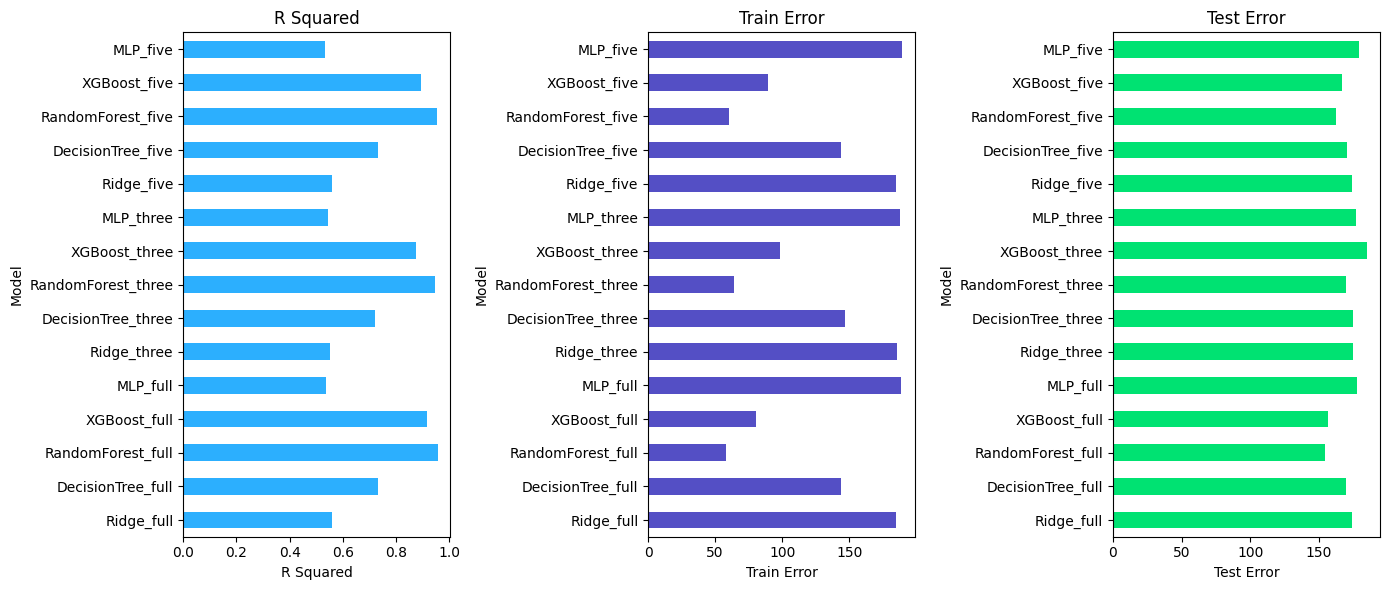

In [40]:
# Create figure and subplots
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

# Create R-squared plot
df_barh.plot(kind='barh', x='model_with_data_set', y='r2', color='#2caffe', ax=ax2, legend=False)
ax2.set_xlabel('R Squared')
ax2.set_ylabel('Model')
ax2.set_title('R Squared')

# Create train error plot
df_train_error.plot(kind='barh', x='model_with_data_set', y='train_error', color='#544fc5', ax=ax3, legend=False)
ax3.set_xlabel('Train Error')
ax3.set_ylabel('Model')
ax3.set_title('Train Error')

# Create test error plot
df_test_error.plot(kind='barh', x='model_with_data_set', y='test_error', color='#00e272', ax=ax4, legend=False)
ax4.set_xlabel('Test Error')
ax4.set_ylabel('Model')
ax4.set_title('Test Error')

# Fit figure
plt.tight_layout()

# Show figure
plt.show()

### Model Evaluation <a id='model-evaluation'></a>

In [41]:
# Drop columns used for naming in plots
pred_df = pred_df.drop(columns=['feature_set_2', 'model_with_data_set'])

#### Highest R Squared <a id='highest-r-squared'></a>

In [42]:
# Get highest r2 scores
pred_df.nlargest(n=5, columns='r2', keep='all')

,regression_model,feature_set,train_error,test_error,r2
2,RandomForest,full_dataset,57.755719,154.368938,0.956744
12,RandomForest,five_best,60.181668,162.560967,0.953034
7,RandomForest,three_best,64.042672,169.882390,0.946814
3,XGBoost,full_dataset,80.730387,156.188258,0.915486
13,XGBoost,five_best,89.557364,166.404869,0.895994


#### Minimum Train Error <a id='min-train-error'></a>

In [43]:
# Get lowest training dataset errors
pred_df.nsmallest(n=5, columns='train_error', keep='all')

,regression_model,feature_set,train_error,test_error,r2
2,RandomForest,full_dataset,57.755719,154.368938,0.956744
12,RandomForest,five_best,60.181668,162.560967,0.953034
7,RandomForest,three_best,64.042672,169.882390,0.946814
3,XGBoost,full_dataset,80.730387,156.188258,0.915486
13,XGBoost,five_best,89.557364,166.404869,0.895994


#### Minimum Test Error <a id='min-test-error'></a>

In [44]:
# Get lowest test dataset errors
pred_df.nsmallest(n=5, columns='test_error', keep='all')

,regression_model,feature_set,train_error,test_error,r2
2,RandomForest,full_dataset,57.755719,154.368938,0.956744
3,XGBoost,full_dataset,80.730387,156.188258,0.915486
12,RandomForest,five_best,60.181668,162.560967,0.953034
13,XGBoost,five_best,89.557364,166.404869,0.895994
1,DecisionTree,full_dataset,143.471063,169.300699,0.733078


### Grid Search in Random Forest <a id='grid-search-random-forest'></a>

- Grid search is a technique for hyperparameter tuning
- Different combinations of hyperparameters are tested to find best performing model

In [45]:
# Set feature variables
X = result.drop(columns='price')

# Set target variable
y = result['price']

# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label model name
model_name = 'Random Forest'

# Initialize model
model = RandomForestRegressor(random_state=42)

# Fit model to training dataset
model.fit(X_train, y_train)

# Make predictions on training datset
y_train_pred = model.predict(X_train)

# Make predictions on test dataset
y_test_pred = model.predict(X_test)

# Calculate training error using mean squared error
train_error_f = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate test error using mean squared error
test_error_f = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R2 score on training dataset
r2_f = r2_score(y_train, y_train_pred)

# Display results
print(f'---Model name = {model_name}---')
print(f'Train error = {train_error_f}')
print(f'Test error = {test_error_f}')
print(f'R squared score = {r2_f}')
print('-' * 50)

---Model name = Random Forest---
Train error = 57.75571879548165
Test error = 154.36893753359774
R squared score = 0.9567441374542804
--------------------------------------------------


In [46]:
# Get hyperparameters of model as dictionary
model.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [47]:
# Get names of all available scorers
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [48]:
# Create parameter grid based on results of random search
param_grid = {
    'bootstrap': [True],
    'ccp_alpha': [0.0],
    'criterion': ['squared_error'],
    'max_depth': [None],
    'max_features': [1.0],
    'max_leaf_nodes': [None],
    'max_samples': [None],
    'min_impurity_decrease': [0.0],
    'min_samples_leaf': [1],
    'min_samples_split': [2],
    'min_weight_fraction_leaf': [0.0],
    'n_estimators': [50, 500, 700],
    'n_jobs': [None],
    'oob_score': [True, False],
    'random_state': [42],
    'verbose': [0],
    'warm_start': [True, False]
}

# Create base model
rf = RandomForestRegressor()

# Instantiate grid search model
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs= -1,
    verbose=0,
    scoring='neg_mean_squared_error'
)

- Measure and display time for `grid_search.fit` process to run
- Understand computational cost of grid search

In [49]:
# Record current time (start)
start_time = time.time()

# Perform grid search on training data
grid_search.fit(X_train, y_train)

# Record current time (end)
end_time = time.time()

# Calculate elapsed time in seconds
elapsed_time_seconds = round(end_time - start_time, ndigits=2)

# Calculate elapsed time in minutes
elapsed_time_minutes = round(elapsed_time_seconds / 60, ndigits=2)

# Print execution time
print(f'Execution time: {elapsed_time_seconds} seconds ({elapsed_time_minutes} minutes)')

Execution time: 30.33 seconds (0.51 minutes)


In [50]:
# Store set of hyperparameters that resulted in best performance by evaluation metric
best_params = grid_search.best_params_

In [51]:
# Set feature variables
X = result.drop(columns='price')

# Set target variable
y = result['price']

# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Label model name
model_name = 'Random Forest'

# Initialize and set parameters for model
model = RandomForestRegressor().set_params(**best_params)

# Fit model on training dataset
model.fit(X_train, y_train)

# Make predictions on training dataset
y_train_pred = model.predict(X_train)

# Make predictions on test dataset
y_test_pred = model.predict(X_test)

# Calculate training error using mean squared error
train_error_gr = mean_squared_error(y_train, y_train_pred, squared=False)

# Calculate test error using mean squared error
test_error_gr = mean_squared_error(y_test, y_test_pred, squared=False)

# Calculate R2 score on training dataset
r2_gr = r2_score(y_train, y_train_pred)

# Display results
print(f'---Model name = {model_name}---')
print(f'Train error = {train_error_gr}')
print(f'Test error = {test_error_gr}')
print(f'R squared score = {r2_gr}')
print('-' * 50)

---Model name = Random Forest---
Train error = 56.51226576818291
Test error = 154.25749133821523
R squared score = 0.9585866435847453
--------------------------------------------------


### Scaling <a id='scaling'></a>

#### Min-Max Scaling <a id='min-max-scaling'></a>

- Normalize values of features and target variables

In [52]:
# Set feature variables
X = result.drop(columns='price')

# Set target variable
y = result['price']

# Convert target variable into NumPy array
# Reshape array to have one column and as many rows as required
# Reshaping ensures compatibility with machine learning models that expect target variable as two-dimensional array
y = np.asanyarray(a=y).reshape((-1, 1))

In [53]:
# Create instance of MinMaxScaler for X (features)
X_scaler = MinMaxScaler()

# Fit scaler to X and transform X using learned scaling parameters
X_scaled = X_scaler.fit_transform(X)

# Create instance of MinMaxScaler for y (target values)
y_scaler = MinMaxScaler()

# Fit scaler to y and transform y using learned scaling parameters
y_scaled = y_scaler.fit_transform(y)

In [54]:
# Split scaled data into training and test datasets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [55]:
# Return flattened data as an ndarray or ExtensionArray
y_train_scaled = y_train_scaled.ravel()
y_test_scaled = y_test_scaled.ravel()

In [56]:
# Initialize and set parameters for model
model = RandomForestRegressor(**best_params)

# Fit model on scaled training dataset
model.fit(X_train_scaled, y_train_scaled)

# Make predictions on scaled training dataset and inverse transform to original scale
y_predict_train_minmax = y_scaler.inverse_transform(model.predict(X_train_scaled).reshape(-1, 1))

# Calculate training error using mean squared error
rmse_error_train_minmax = mean_squared_error(y_train, y_predict_train_minmax[:, 0], squared=False)

# Calculate R2 score
r2_minmax = r2_score(y_train, y_predict_train_minmax)

In [57]:
# Initialize and set parameters for model
model = RandomForestRegressor(**best_params)

# Fit model on scaled test dataset
model.fit(X_test_scaled, y_test_scaled)

# Make predictions on scaled test dataset and inverse transform to original scale
y_predict_test_minmax = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))

# Calculate test error using mean squared error
rmse_error_test_minmax = mean_squared_error(y_test, y_predict_test_minmax[:, 0], squared=False)

In [58]:
# Display results
print(f'Normalized train error = {rmse_error_train_minmax}')
print(f'Normalized test error = {rmse_error_test_minmax}')
print(f'Normalized R-squared score = {r2_minmax}')

Normalized train error = 56.52133745798042
Normalized test error = 59.18919660891543
Normalized R-squared score = 0.9585733466740054


#### Standard Scaling <a id='standard-scaling'></a>

- Standardization (z-score normalization) of features and target variables
- Zero mean and unit variance

In [59]:
# Create instance of StandardScaler for X (features)
X_scaler = StandardScaler()

# Fit scaler to X and transform X using learned scaling parameters
X_scaled = X_scaler.fit_transform(X)

# Create instance of StandardScaler for y (target values)
y_scaler = StandardScaler()

# Fit scaler to y and transform y using learned scaling parameters
y_scaled = y_scaler.fit_transform(y)

In [60]:
# Split scaled data into training and test datasets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [61]:
# Return flattened data as an ndarray or ExtensionArray
y_train_scaled = y_train_scaled.ravel()
y_test_scaled = y_test_scaled.ravel()

In [62]:
# Initialize and set parameters for model
model = RandomForestRegressor(**best_params)

# Fit model on scaled training dataset
model.fit(X_train_scaled, y_train_scaled)

# Make predictions on scaled training dataset and inverse transform to original scale
y_predict_train_standard = y_scaler.inverse_transform(model.predict(X_train_scaled).reshape(-1, 1))

# Calculate training error using mean squared error
rmse_error_train_standard = mean_squared_error(y_train, y_predict_train_standard[:, 0], squared=False)

# Calculate R2 score
r2_standard = r2_score(y_train, y_predict_train_standard)

In [63]:
# Initialize and set parameters for model
model = RandomForestRegressor(**best_params)

# Fit model on scaled test dataset
model.fit(X_test_scaled, y_test_scaled)

# Make predictions on scaled test dataset and inverse transform to original scale
y_predict_test_standard = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))

# Calculate test error using mean squared error
rmse_error_test_standard = mean_squared_error(y_test, y_predict_test_standard[:, 0], squared=False)

In [64]:
print(f'Normalized train error = {rmse_error_train_standard}')
print(f'Normalized test error = {rmse_error_test_standard}')
print(f'Normalized R-squared score = {r2_standard}')

Normalized train error = 56.487107113560775
Normalized test error = 59.23562677932352
Normalized R-squared score = 0.9586235089411177


#### Robust Scaling <a id='robust-scaling'></a>

- Robust scaling is less influenced by outliers compared to MinMax scaling and Standard scaling.

In [65]:
# Create instance of RobustScaler for X (features)
X_scaler = RobustScaler()

# Fit scaler to X and transform X using learned scaling parameters
X_scaled = X_scaler.fit_transform(X)

# Create instance of RobustScaler for y (target values)
y_scaler = RobustScaler()

# Fit scaler to y and transform y using learned scaling parameters
y_scaled = y_scaler.fit_transform(y)

In [66]:
# Split scaled data into training and test datasets
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

In [67]:
# Return flattened data as an ndarray or ExtensionArray
y_train_scaled = y_train_scaled.ravel()
y_test_scaled = y_test_scaled.ravel()

In [68]:
# Initialize and set parameters for model
model = RandomForestRegressor(**best_params)

# Fit model on scaled training dataset
model.fit(X_train_scaled, y_train_scaled)

# Make predictions on scaled training dataset and inverse transform to original scale
y_predict_train_robust = y_scaler.inverse_transform(model.predict(X_train_scaled).reshape(-1, 1))

# Calculate training error using mean squared error
rmse_error_train_robust = mean_squared_error(y_train, y_predict_train_robust[:, 0], squared=False)

# Calculate R2 score
r2_robust = r2_score(y_train, y_predict_train_robust)

In [69]:
# Initialize and set parameters for model
model = RandomForestRegressor(**best_params)

# Fit model on scaled test dataset
model.fit(X_test_scaled, y_test_scaled)

# Make predictions on scaled test dataset and inverse transform to original scale
y_predict_test_robust = y_scaler.inverse_transform(model.predict(X_test_scaled).reshape(-1, 1))

# Calculate test error using mean squared error
rmse_error_test_robust = mean_squared_error(y_test, y_predict_test_robust[:, 0], squared=False)

In [70]:
print(f'Normalized train error = {rmse_error_train_robust}')
print(f'Normalized test error = {rmse_error_test_robust}')
print(f'Normalized R-squared score = {r2_robust}')

Normalized train error = 56.57405224249394
Normalized test error = 59.04469114746593
Normalized R-squared score = 0.9584960372696737


### Visualize Machine Learning Model Results <a id='ml-model-results'></a>

In [71]:
# Store evaluation metrics for different configurations of predictive model
pred_dict = {
    'Technique': ['Base Model', 'Grid Search', 'Min-Max Scaling', 'Standard Scaling', 'Robust Scaling'],
    'Train Error': [train_error_f, train_error_gr, rmse_error_train_minmax, rmse_error_train_standard, rmse_error_train_robust],
    'Test Error': [test_error_f, test_error_gr, rmse_error_test_minmax, rmse_error_test_standard, rmse_error_test_robust],
    'R2': [r2_f, r2_gr, r2_minmax, r2_standard, r2_robust]
}

In [72]:
# Create DataFrame from dictionary
pred_df = pd.DataFrame(pred_dict)

# Show processed DataFrame
pred_df

,Technique,Train Error,Test Error,R2
0,Base Model,57.755719,154.368938,0.956744
1,Grid Search,56.512266,154.257491,0.958587
2,Min-Max Scaling,56.521337,59.189197,0.958573
3,Standard Scaling,56.487107,59.235627,0.958624
4,Robust Scaling,56.574052,59.044691,0.958496


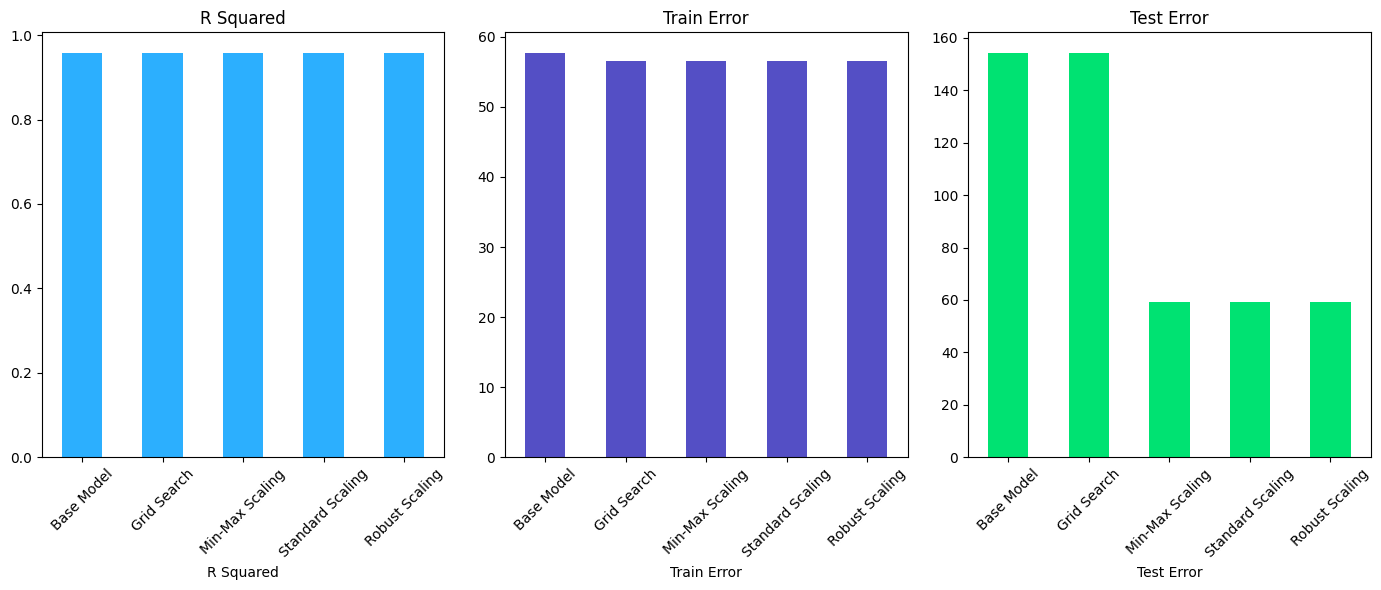

In [73]:
# Create figure and subplots
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

# Create R-squared plot
pred_df.plot(kind='bar', x='Technique', y='R2', color='#2caffe', ax=ax2, legend=False)
ax2.set_xlabel('R Squared')
ax2.set_title('R Squared')
ax2.tick_params(axis='x', labelrotation=45)

# Create train error plot
pred_df.plot(kind='bar', x='Technique', y='Train Error', color='#544fc5', ax=ax3, legend=False)
ax3.set_xlabel('Train Error')
ax3.set_title('Train Error')
ax3.tick_params(axis='x', labelrotation=45)

# Create test error plot
pred_df.plot(kind='bar', x='Technique', y='Test Error', color='#00e272', ax=ax4, legend=False)
ax4.set_xlabel('Test Error')
ax4.set_title('Test Error')
ax4.tick_params(axis='x', labelrotation=45)

# Fit figure
plt.tight_layout()

# Show figure
plt.show()

## Deep Learning <a id='deep-learning'></a>

In [74]:
# Set feature variables
X = result.drop(columns='price')

# Set target variable
y = result['price']
# y = np.asanyarray(y).reshape(-1, 1)

In [75]:
# Split data into training and test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
# Convert NumPy array to TensorFlow tensor
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)

Epoch 1/30
250/250 [==============================] - 1s 5ms/step - loss: 147601.0938 - mean_absolute_error: 268.3280 - val_loss: 90544.3828 - val_mean_absolute_error: 219.0211
Epoch 2/30
250/250 [==============================] - 1s 4ms/step - loss: 90632.2812 - mean_absolute_error: 210.2799 - val_loss: 73572.1719 - val_mean_absolute_error: 190.4278
Epoch 3/30
250/250 [==============================] - 1s 4ms/step - loss: 75026.3672 - mean_absolute_error: 184.0037 - val_loss: 60558.1719 - val_mean_absolute_error: 169.1112
Epoch 4/30
250/250 [==============================] - 1s 4ms/step - loss: 63598.0781 - mean_absolute_error: 164.5691 - val_loss: 51801.4844 - val_mean_absolute_error: 154.2904
Epoch 5/30
250/250 [==============================] - 1s 4ms/step - loss: 55849.0742 - mean_absolute_error: 151.9290 - val_loss: 46140.4258 - val_mean_absolute_error: 142.6467
Epoch 6/30
250/250 [==============================] - 1s 4ms/step - loss: 50730.9609 - mean_absolute_error: 143.7924 - 

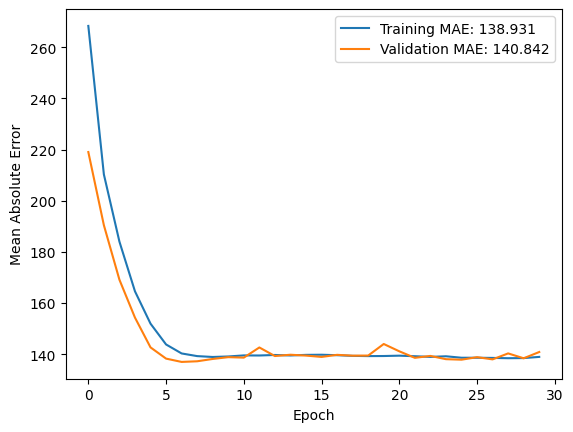

Execution time: 31.36 seconds (0.51 minutes)


In [77]:
# Record current time (start)
start = time.time()

# Set random seed for reproducible results
tf.random.set_seed(seed=42)

# Define model
model = Sequential([
    Dense(units=64, activation='relu', input_shape=[X_train.shape[1]]),
    Dense(units=1)
])

# Compile model with low learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
             loss=MeanSquaredError(),
             metrics=[MeanAbsoluteError()]
             )

# Set number of epochs for model fitting
epochs = 30

# Fit model to training data
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Make predictions on training dataset
y_train_pred = model.predict(X_train)

# Calculate R-squared score on training dataset
r2_first = r2_score(y_train, y_train_pred)

# Get first mean absolute error on training dataset
mae_first = history.history['mean_absolute_error'][epochs - 1]

# Get first mean absolute error on validation (test) dataset
val_mae_first = history.history['val_mean_absolute_error'][epochs - 1]

# Plot training and validation Mean Absolute Error
plt.plot(history.history['mean_absolute_error'], label=f'Training MAE: {mae_first:.3f}')
plt.plot(history.history['val_mean_absolute_error'], label=f'Validation MAE: {val_mae_first:.3f}')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Record current time (end)
end = time.time()

# Calculate elapsed time in seconds
elapsed_time_seconds = end - start
elapsed_time_seconds = round(elapsed_time_seconds, ndigits=2)

# Calculate elapsed time in minutes
elapsed_time = round(elapsed_time_seconds / 60, ndigits=2)

# Display result
print(f'Execution time: {elapsed_time_seconds} seconds ({elapsed_time_minutes} minutes)')

A more complex deep learning model will be explored below.

Epoch 1/30
250/250 [==============================] - 4s 15ms/step - loss: 1226092.5000 - mean_absolute_error: 467.3755 - val_loss: 46359.6133 - val_mean_absolute_error: 151.3615
Epoch 2/30
250/250 [==============================] - 4s 14ms/step - loss: 48185.6836 - mean_absolute_error: 145.6685 - val_loss: 46279.3906 - val_mean_absolute_error: 147.8646
Epoch 3/30
250/250 [==============================] - 4s 14ms/step - loss: 49360.3828 - mean_absolute_error: 151.4978 - val_loss: 47927.9531 - val_mean_absolute_error: 153.0695
Epoch 4/30
250/250 [==============================] - 4s 14ms/step - loss: 48352.3242 - mean_absolute_error: 149.5421 - val_loss: 39764.0273 - val_mean_absolute_error: 140.3598
Epoch 5/30
250/250 [==============================] - 4s 14ms/step - loss: 46591.5938 - mean_absolute_error: 145.4414 - val_loss: 43326.7617 - val_mean_absolute_error: 156.8267
Epoch 6/30
250/250 [==============================] - 4s 14ms/step - loss: 46466.0977 - mean_absolute_error: 145.

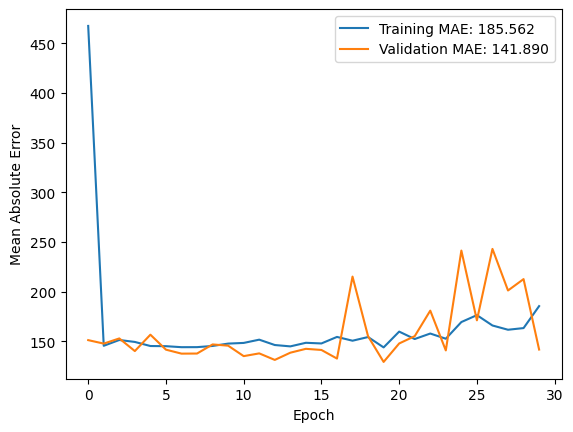

Execution time: 107.13 seconds (1.79 minutes)


In [78]:
# Record current time (start)
start = time.time()

# Set random seed for reproducible results
tf.random.set_seed(seed=42)

# Define model with more layers
model = Sequential([
    Dense(units=64, activation='relu', input_shape=[X_train.shape[1]], kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=8, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=1)
])

# Compile model with lower learning rate
model.compile(optimizer=Adam(learning_rate=0.0007),
             loss=MeanSquaredError(),
             metrics=[MeanAbsoluteError()]
             )

# Set number of epochs for model fitting
# This number can be set to 1000 for more complex model
epochs = 30

# Fit model to training data
# If epochs is set to large number, set `verbose=0` to suppress output
history = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1, validation_data=(X_test, y_test))

# Make predictions on training dataset
y_train_pred = model.predict(X_train)

# Calculate R-squared score on training dataset
r2_second = r2_score(y_train, y_train_pred)

# Get second mean absolute error on training dataset
mae_second = history.history['mean_absolute_error'][epochs - 1]

# Get second mean absolute error on validation (test) dataset
val_mae_second = history.history['val_mean_absolute_error'][epochs - 1]

# Plot training and validation Mean Squared Error
plt.plot(history.history['mean_absolute_error'], label=f'Training MAE: {mae_second:.3f}')
plt.plot(history.history['val_mean_absolute_error'], label=f'Validation MAE: {val_mae_second:.3f}')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Record current time (end)
end = time.time()

# Calculate elapsed time in seconds
elapsed_time_seconds = end - start
elapsed_time_seconds = round(elapsed_time_seconds, ndigits=2)

# Calculate elapsed time in minutes
elapsed_time = round(elapsed_time_seconds / 60, ndigits=2)

# Display result
print(f'Execution time: {elapsed_time_seconds} seconds ({elapsed_time} minutes)')

In [79]:
# Store evaluation metrics for different configurations of deep learning model
pred_dict = {
    'Algorithm': ['Deep Learning', 'Deep Learning optimized'],
    'Train Error': [mae_first, mae_second],
    'Test Error': [val_mae_first, val_mae_second],
    'R2': [r2_first, r2_second]
}

In [80]:
# Create DataFrame from dictionary
pred_df = pd.DataFrame(pred_dict)

# Show processed DataFrame
pred_df

,Algorithm,Train Error,Test Error,R2
0,Deep Learning,138.931259,140.842056,0.433096
1,Deep Learning optimized,185.561890,141.890045,0.448759


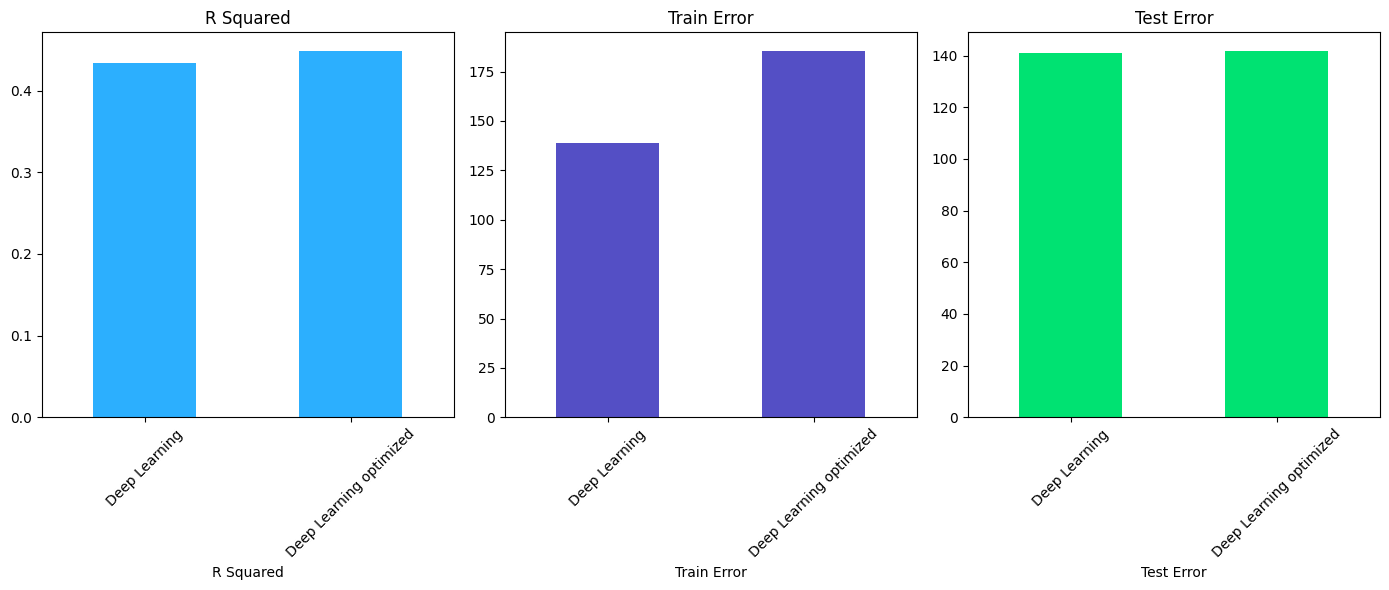

In [81]:
# Create figure and subplots
fig, (ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=3, figsize=(14, 6))

# Create R-squared plot
pred_df.plot(kind='bar', x='Algorithm', y='R2', color='#2caffe', ax=ax2, legend=False)
ax2.set_xlabel('R Squared')
ax2.set_title('R Squared')
ax2.tick_params(axis='x', labelrotation=45)

# Create train error plot
pred_df.plot(kind='bar', x='Algorithm', y='Train Error', color='#544fc5', ax=ax3, legend=False)
ax3.set_xlabel('Train Error')
ax3.set_title('Train Error')
ax3.tick_params(axis='x', labelrotation=45)

# Create test error plot
pred_df.plot(kind='bar', x='Algorithm', y='Test Error', color='#00e272', ax=ax4, legend=False)
ax4.set_xlabel('Test Error')
ax4.set_title('Test Error')
ax4.tick_params(axis='x', labelrotation=45)

# Fit figure
plt.tight_layout()

# Show figure
plt.show()

Thie notebook was inspired by the [Predicting Price](https://platform.stratascratch.com/data-projects/predicting-price) data project on [StrataScratch](https://www.stratascratch.com/).